## Compare Step-Index computations

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

import gc
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.coupling import StepIndexFiberDegenCoupler
from mmfsim.transforms import fourier_transform
from mmfsim.devices import MockDeformableMirror

### Simulation variables

In [23]:
fiber_radius = 25e-6
fiber_length = 1e0
power_n = 7
power_n_fourier = 11
grid_length_fourier = 2 ** power_n_fourier
grid_length = 2 ** power_n
grid_size = 2 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.4665, n2=1.45)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [24]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.4665
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.219
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46641487  0.          0.          1.        ]
 [ 1.46628389  2.          1.          1.        ]
 [ 1.46611179  4.          2.          1.        ]
 [ 1.46605151  1.          0.          2.        ]
 [ 1.46590084  6.          3.          1.        ]
 [ 1.46577563  3.          1.          2.        ]
 [ 1.46565244  8.          4.          1.        ]
 [ 1.46545734  5.          2.          2.        ]
 [ 1.46539799  2.          0.          3.        ]
 [ 1.46536754 10.          5.          1.        ]]


In [25]:
fiber.compute_modes_fields(grid)
clear_output(wait=False)

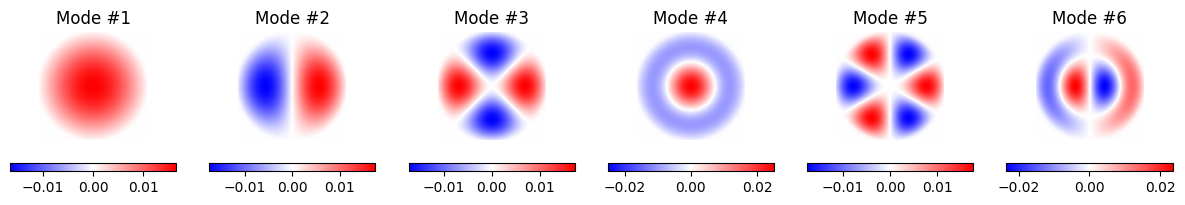

In [26]:
plt.figure(figsize=(15, 2))

max_modes = 6

for i in range(max_modes):
    plt.subplot(1, max_modes, i+1)
    mode = fiber._modes[:, :, 0, i]
    plt.imshow(mode, cmap='bwr', vmin=-np.max(np.abs(mode)), vmax=+np.max(np.abs(mode)))
    plt.axis('off')
    plt.title(f'Mode #{i+1}')
    plt.colorbar(orientation='horizontal')

### Evaluate coupling qualities from sampled DMs


Define some helping functions first

In [67]:
import torch
from torch.nn import AdaptiveAvgPool2d, UpsamplingNearest2d

def convert_field_to_dm(field: np.array, n: int):
    with torch.no_grad():
        downsampler = AdaptiveAvgPool2d(output_size=(n, n))
        upsampler =  UpsamplingNearest2d(size=field.shape)

        downsampled = (
            downsampler(torch.from_numpy(np.real(field[np.newaxis, np.newaxis, ...])))
            + 1j * downsampler(torch.from_numpy(np.imag(field[np.newaxis, np.newaxis, ...])))
        )

        resampled = (
            upsampler(torch.real(downsampled))
            + 1j * upsampler(torch.imag(downsampled))
        )

    return resampled.squeeze().cpu().detach().numpy()

(<Figure size 1500x400 with 1 Axes>,
 <Axes: title={'center': 'Energy percentage on LP modes (269 modes, total energy: 81.5%)'}, xlabel='LP$_{n,m}$ mode', ylabel='Energy percentage [%]'>,
 <BarContainer object of 140 artists>)

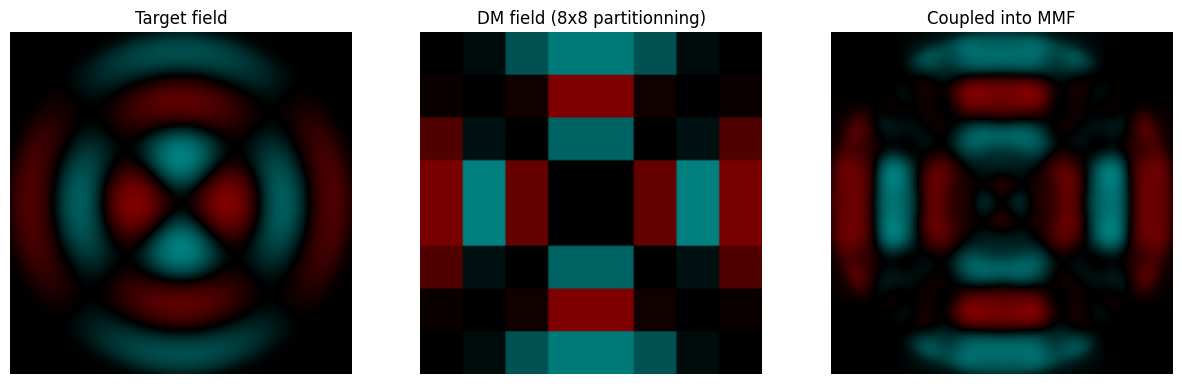

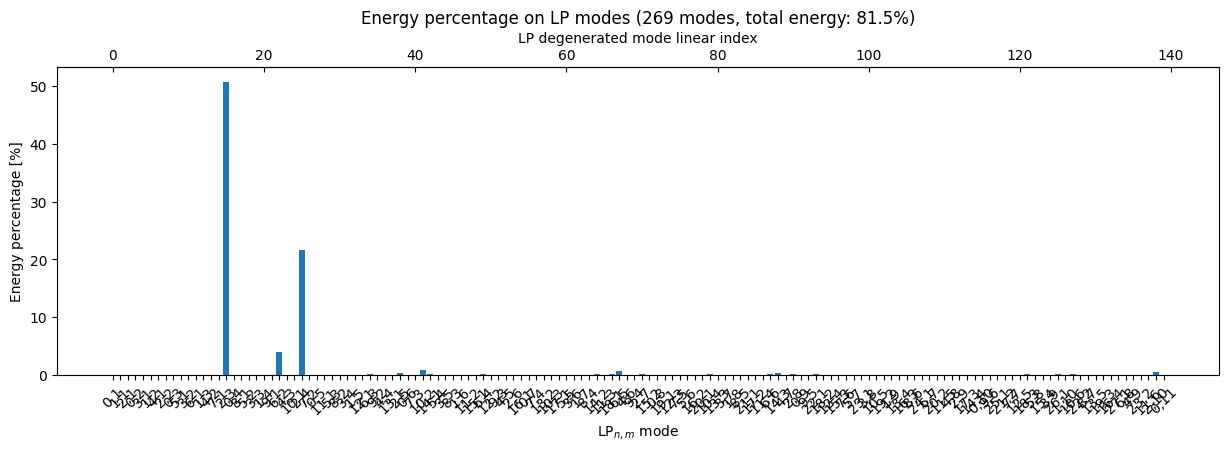

In [94]:
from waveoptics.plots.plots import complex_imshow, complex_to_hsv
from scipy.ndimage import gaussian_filter

mode_number = 15
orientation = 0
dm_n = 8
target_field = np.complex64(fiber._modes[:, :, orientation, mode_number])
new_field = convert_field_to_dm(target_field, n=dm_n)
coupled_in = StepIndexFiberDegenCoupler(new_field, grid, fiber, N_modes=fiber._N_modes_degen)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(complex_to_hsv(target_field))
plt.axis('off')
plt.title('Target field')

plt.subplot(1, 3, 2)
plt.imshow(complex_to_hsv(new_field))
plt.axis('off')
plt.title(f'DM field ({dm_n}x{dm_n} partitionning)')

plt.subplot(1, 3, 3)
plt.imshow(complex_to_hsv(coupled_in.field))
plt.title(f'Coupled into MMF')
plt.axis('off')

coupled_in.plot_coefficients(orients=False)
